In [8]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Classification

In [17]:
def calculate_loss(X, y, model):
    pred = model(X)
    return F.binary_cross_entropy(pred, y.unsqueeze(1)) 

def train(model, train_loader, val_loader, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    val_losses = []
    model.to(device)
    for i in tqdm(range(epochs)):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Validation
        loss_mean = 0 
        elements = 0
        for X, y in iter(val_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        val_losses.append(loss_mean / elements)
        #print("Epoch", i, "| Train loss", train_losses[-1], "| Validation loss", val_losses[-1])
    return train_losses, val_losses

def plot_losses(train_l, val_l):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_l)), train_l, label="train")
    plt.plot(range(len(val_l)), val_l, label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
embedding_path = '/content/drive/My Drive/hateful_memes/embeddings/'
labels_train = torch.Tensor(np.load(embedding_path + 'labels.npy'))
labels_val = torch.Tensor(np.load(embedding_path + 'labels_val.npy'))

In [20]:
def get_classifier(model_name, n_hidden=256, n_input=2048):
    classifier = nn.Sequential(
                  nn.Linear(n_input, n_hidden),
                  nn.ReLU(),
                  nn.Linear(n_hidden, 1),
                  nn.Sigmoid())

    path_train = embedding_path + model_name + '.npy'
    path_val = embedding_path + model_name + '_val.npy'

    emb_train = torch.Tensor(np.load(path_train).astype(np.float32))
    emb_val = torch.Tensor(np.load(path_val).astype(np.float32))

    dataset_train = TensorDataset(emb_train, labels_train)
    dataset_val = TensorDataset(emb_val, labels_val)

    train_loader = DataLoader(dataset_train, batch_size=128)
    val_loader = DataLoader(dataset_val, batch_size=128)
    return classifier, train_loader, val_loader

#### BYOL with not pretrained resnet50


100%|██████████| 600/600 [02:16<00:00,  4.40it/s]


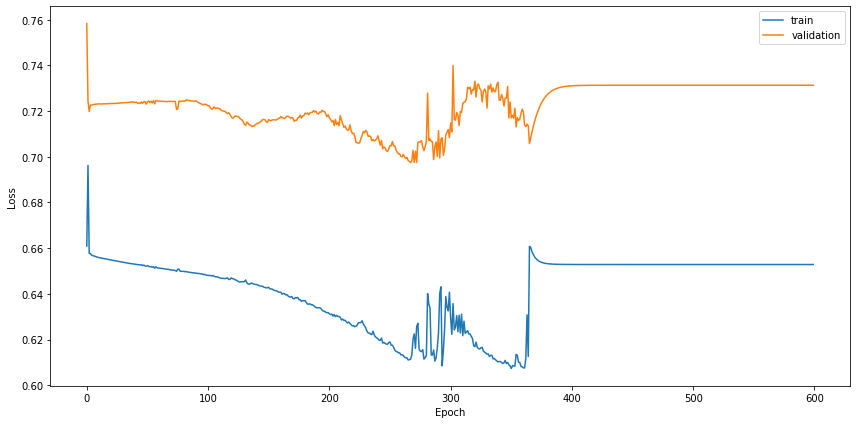

In [26]:
classifier, train_loader, val_loader = get_classifier(model_name='resnet50_not_pretrained_epoch=830')
train_l, val_l = train(classifier, train_loader, val_loader, 600)
plot_losses(train_l, val_l)

#### Resnet 50

100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]


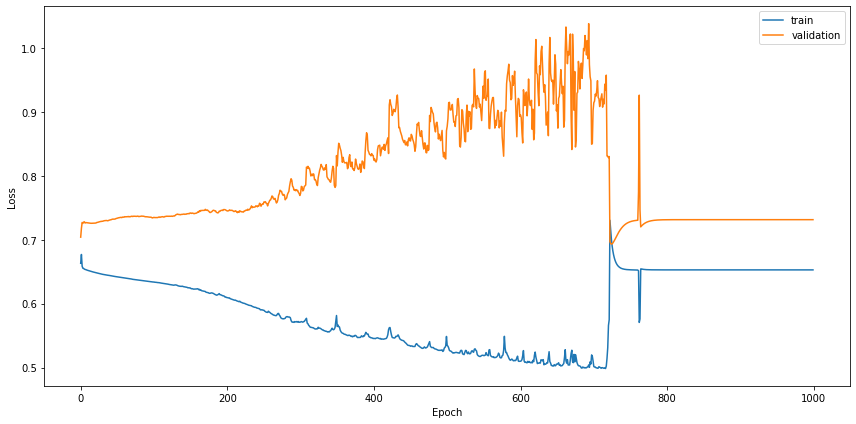

In [25]:
classifier, train_loader, val_loader = get_classifier(model_name='resnet50')
train_l, val_l = train(classifier, train_loader, val_loader, 1000)
plot_losses(train_l, val_l)